In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# # %pip install Pillow
# from PIL import Image

# def split_image_parts(img_path, save_dir, prefix):
#     img = Image.open(img_path)
#     width, height = img.size

#     parts = {}

#     # Cross split (4 quadrants)
#     parts['top_left'] = img.crop((0, 0, width // 2, height // 2))
#     parts['top_right'] = img.crop((width // 2, 0, width, height // 2))
#     parts['bottom_left'] = img.crop((0, height // 2, width // 2, height))
#     parts['bottom_right'] = img.crop((width // 2, height // 2, width, height))

#     # 3 vertical parts
#     third_w = width // 3
#     parts['left'] = img.crop((0, 0, third_w, height))
#     parts['middle'] = img.crop((third_w, 0, 2 * third_w, height))
#     parts['right'] = img.crop((2 * third_w, 0, width, height))

#     # 3 horizontal parts
#     third_h = height // 3
#     parts['top'] = img.crop((0, 0, width, third_h))
#     parts['center'] = img.crop((0, third_h, width, 2 * third_h))
#     parts['bottom'] = img.crop((0, 2 * third_h, width, height))

#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)  # Create the directory if it doesn't exist
    
#     for part_name, part_image in parts.items():
#         save_path = os.path.join(save_dir, f"{prefix}_{part_name}.jpg")
#         part_image.save(save_path)

#     return parts

In [3]:
# import os
# import csv
# import random
# from PIL import Image
# from numpy import asarray

# def make_pairs(page_dir, save_dir, output_file="pairs.csv"):
#     page_files = sorted(os.listdir(page_dir))  # Ensure pages are in order
#     pairs = []
    
#     img1_path = os.path.join(page_dir, page_files[0])
#     prefix1 = f"page{3}"
#     parts1 = split_image_parts(img1_path, save_dir, prefix1)

#     img2_path = os.path.join(page_dir, page_files[1])
#     prefix2 = f"page{4}"
#     parts2 = split_image_parts(img2_path, save_dir, prefix2)

#     # Loop through consecutive page indices
#     for i in range(2, len(page_files), +1):
#         imgi_path = os.path.join(page_dir, page_files[i])

#         prefixi = f"page{i+3}"
#         prefixi2 = f"page{i+1}"

#         partsi = split_image_parts(imgi_path, save_dir, prefixi)

#         partsi2 = {}
#         for part_name in ["top_left","top_right","bottom_left","bottom_right","top", "middle", "bottom", "left", "center", "right"]:
#             filename = os.path.join(save_dir, f"{prefixi2}_{part_name}.jpg")
#             partsi2[part_name] = Image.open(filename)  # OPEN as PIL Image

#         # Positive pairs: same parts from consecutive pages
#         for key in partsi:
#             pairs.append((partsi2[key], partsi[key], 1))

#         j_candidates = list(range(i-4, -1, -2))

#         # Pick one random j from the list (if any exist)
#         if j_candidates:
#             j = random.choice(j_candidates)
#             prefixj = f"page{j+3}"
#             parts_neg = {}

#             for part_name in ["top_left", "top_right", "bottom_left", "bottom_right",
#                       "top", "middle", "bottom", "left", "center", "right"]:
#                 filename = os.path.join(save_dir, f"{prefixj}_{part_name}.jpg")
#                 parts_neg[part_name] = Image.open(filename)  # OPEN as PIL Image
            
#             for key in partsi:
#                 pairs.append((parts_neg[key], partsi[key], 0))
                
#      # Save all pairs to CSV at the end
#     with open(output_file, "w", newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(["img1", "img2", "label"])  # header
#         writer.writerows(csv_rows)
        
#     return pairs


In [4]:
import os
import csv
import random
from PIL import Image
from numpy import asarray

def make_pairs(page_dir, output_file="pairs.csv"):
    page_files = sorted(os.listdir(page_dir)) 
    pairs = []
    csv_rows = []

    for i in range(0, len(page_files) - 2, +1):
        img1_path = os.path.join(page_dir, page_files[i])
        img2_path = os.path.join(page_dir, page_files[i+2])
        csv_rows.append((img1_path, img2_path, 1))

        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        pairs.append((img1, img2, 1))

        if(i < len(page_files) - 4):
            j_candidates = list(range(i + 4, len(page_files), +2))
            if j_candidates:
                j = random.choice(j_candidates)
            imgj_path = os.path.join(page_dir, page_files[j])
            csv_rows.append((img1_path, imgj_path, 0))

            imgj = Image.open(imgj_path)
            pairs.append((img1, imgj, 0))

    with open(output_file, "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["img1", "img2", "label"])  # header
        writer.writerows(csv_rows)
        
    return pairs

In [5]:
dataset = make_pairs("manuscript_images")

In [6]:
# import pandas as pd

# df = pd.read_csv("pairs.csv")
# print(df['img1'])


In [7]:
# %pip install tensorflow_datasets

# split
import numpy as np
import pandas as pd

# Create indices
dataset_size = len(dataset)
f = pd.DataFrame(dataset, columns=["img1", "img2", "label"])
# shuffle the DataFrame rows
f = f.sample(frac = 1)

# Split sizes
train_split = int(0.8 * dataset_size)
val_split = int(0.9 * dataset_size)

# Create Subset datasets
train_dataset = f.iloc[: train_split]
val_dataset   = f.iloc[train_split:val_split]
test_dataset  = f[val_split:]

In [8]:
from numpy import asarray
import numpy as np

def preprocess_image(img, size=(256, 256)):
    return asarray(img.resize(size)) / 255.0
    # return asarray(img).astype("float32") / 255.0  # Normalize to [0,1]

# Convert each dataset split to NumPy arrays
x1t = np.stack(train_dataset["img1"].apply(preprocess_image))
x2t = np.stack(train_dataset["img2"].apply(preprocess_image))
yt = train_dataset["label"].astype("float32").values

x1v = np.stack(val_dataset["img1"].apply(preprocess_image))
x2v = np.stack(val_dataset["img2"].apply(preprocess_image))
yv = val_dataset["label"].astype("float32").values

x1test = np.stack(test_dataset["img1"].apply(preprocess_image))
x2test = np.stack(test_dataset["img2"].apply(preprocess_image))
ytest = test_dataset["label"].astype("float32").values


In [9]:
from typing_extensions import Concatenate
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


img_A_inp = Input((256, 256, 3), name= 'img_A_inp')
img_B_inp = Input((256, 256, 3), name= 'img_B_inp')

def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1), # 3x3 conv kernel, stride 1
                     BatchNormalization(), # Normalize activations
                     ReLU()]) # Activation function


DEPTH = 64
cnn = Sequential([Reshape((256, 256, 3)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH * 2),
                  get_cnn_block(DEPTH * 4),
                  get_cnn_block(DEPTH * 8),
                  GlobalAveragePooling2D(), # Collapse H/W to a vector of size (512,)
                  Dense(64, activation='relu')])

for i, layer in enumerate(cnn.layers):
    print(i, layer.name)

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)


concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)

output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

2025-05-21 13:00:03.123711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747825203.139481 1015231 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747825203.144280 1015231 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747825203.158856 1015231 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747825203.158886 1015231 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747825203.158888 1015231 computation_placer.cc:177] computation placer alr

0 reshape
1 sequential
2 sequential_1
3 sequential_2
4 sequential_3
5 global_average_pooling2d
6 dense


2025-05-21 13:00:10.542254: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-21 13:00:10.542285: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-05-21 13:00:10.542292: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-05-21 13:00:10.542296: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-21 13:00:10.542302: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: v100v2gpu12
2025-05-21 13:00:10.542305: I external/local_xla/xla/stream_executor/cuda/c

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_A_inp           │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_B_inp           │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 64)        │  1,587,648 │ img_A_inp[0][0],  │
│ (Sequential)        │                   │            │ img_B_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ sequential_4[0][… │
│ (Concatenate)       │                   │            │ sequential_4[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,595,969 (6.09 MB)

 Trainable params: 1,594,049 (6.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', AUC(name='auc')])

In [11]:
# If the val loss doesn’t improve for 3 epochs in a row, training will stop early.
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3)

In [12]:
model.fit([x1t, x2t], yt,
          validation_data=([x1v, x2v], yv),
          epochs=10,
          batch_size=8,
          callbacks=[es], 
          verbose=1)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 331s 29s/step - accuracy: 0.5012 - auc: 0.4840 - loss: 0.7505 - val_accuracy: 0.3636 - val_auc: 0.3929 - val_loss: 0.7521
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 321s 29s/step - accuracy: 0.5738 - auc: 0.6318 - loss: 0.6808 - val_accuracy: 0.6364 - val_auc: 0.4464 - val_loss: 0.6818
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 319s 29s/step - accuracy: 0.6241 - auc: 0.7031 - loss: 0.6627 - val_accuracy: 0.6364 - val_auc: 0.2857 - val_loss: 0.6833
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 321s 29s/step - accuracy: 0.7031 - auc: 0.8039 - loss: 0.5907 - val_accuracy: 0.5455 - val_auc: 0.3929 - val_loss: 0.7048
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 318s 29s/step - accuracy: 0.6760 - auc: 0.8010 - loss: 0.5740 - val_accuracy: 0.3636 - val_auc: 0.4107 - val_loss: 0.7782


In [13]:
import tensorflow as tf
import numpy as np

def grad_cam(model, image_a, image_b, layer_name, class_idx=None):
    # Combine input
    inputs = [tf.convert_to_tensor(image_a, dtype=tf.float32),
              tf.convert_to_tensor(image_b, dtype=tf.float32)]

    # Create a model that gives activations + output
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(inputs)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    # Check shape and reduce properly
    if len(grads.shape) == 4:
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # standard conv layer
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    elif len(grads.shape) == 2:
        pooled_grads = tf.reduce_mean(grads, axis=0)  # dense or GAP layer
        conv_outputs = conv_outputs[0]
        heatmap = tf.multiply(pooled_grads, conv_outputs)
    else:
        raise ValueError(f"Unexpected grad shape: {grads.shape}")

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)  # Normalize to [0, 1]
    max_val = tf.reduce_max(heatmap)
    if max_val > 0:
        heatmap /= max_val
    heatmap = heatmap.numpy()

    return heatmap

In [14]:
import matplotlib.pyplot as plt

def show_gradcam(img, heatmap, title="Grad-CAM++"):
    heatmap = np.uint8(255 * heatmap)  # scale to 0–255

    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Heatmap")
    plt.axis("off")

    # Overlay
    plt.subplot(1, 3, 3)
    overlay = img.copy()
    if img.max() <= 1.0:  # normalize if needed
        overlay = (overlay * 255).astype(np.uint8)
    overlay = np.uint8(overlay)
    heatmap_color = plt.cm.jet(heatmap)[:, :, :3] * 255
    overlay = 0.6 * overlay + 0.4 * heatmap_color
    overlay = np.uint8(overlay)

    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [15]:
import tensorflow as tf

def compute_saliency(model, image_a, image_b, class_index=None):
    image_a = tf.convert_to_tensor(image_a)
    image_b = tf.convert_to_tensor(image_b)
    image_a = tf.cast(image_a, tf.float32)
    image_b = tf.cast(image_b, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch([image_a, image_b])
        preds = model([image_a, image_b])
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads_a = tape.gradient(loss, image_a)[0]
    grads_b = tape.gradient(loss, image_b)[0]

    saliency_a = tf.reduce_max(tf.abs(grads_a), axis=-1).numpy()
    saliency_b = tf.reduce_max(tf.abs(grads_b), axis=-1).numpy()

    return saliency_a, saliency_b


In [16]:
import cv2
import numpy as np

def overlay_heatmap_on_image(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Normalize heatmap to range 0–255 and convert to uint8
    heatmap = np.uint8(255 * heatmap)

    # Apply color map
    heatmap_color = cv2.applyColorMap(heatmap, colormap)

    # Resize heatmap to match original image size
    heatmap_color = cv2.resize(heatmap_color, (image.shape[1], image.shape[0]))

    # Convert original image to uint8 if needed
    if image.dtype != np.uint8:
        image = np.uint8(255 * image)

    # Overlay the heatmap on the image
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
    return overlayed


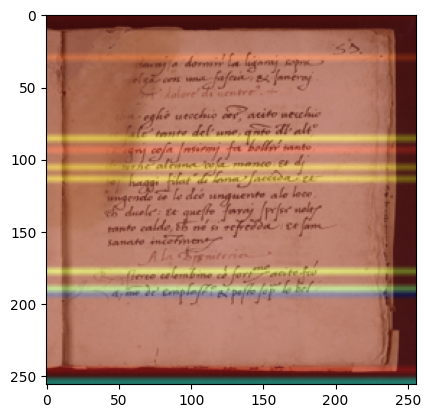

In [17]:
import random

CSV_PATH = 'pairs.csv'

# Load the dataset from CSV
dataset = pd.read_csv(CSV_PATH)

# Shuffle the rows and reset index
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Randomly select two rows from the dataset
random_indices = random.sample(range(len(dataset)), 2)

# Extract the paths for the two random images
image_a_path = dataset.iloc[random_indices[0]]['img1']  # Replace with your actual column name for the image path
image_b_path = dataset.iloc[random_indices[1]]['img2']  # Replace with your actual column name for the image path

# Load and preprocess the images
image_a = Image.open(image_a_path).convert("RGB").resize((256, 256))
image_b = Image.open(image_b_path).convert("RGB").resize((256, 256))

# Convert to NumPy arrays and add batch dimension
image_a = np.expand_dims(np.array(image_a) / 255.0, axis=0)
image_b = np.expand_dims(np.array(image_b) / 255.0, axis=0)

heatmap_a = grad_cam(model, image_a, image_b, layer_name='sequential_4')


result_image_a = overlay_heatmap_on_image(image_a[0], heatmap_a)


plt.imshow(result_image_a)
plt.show()

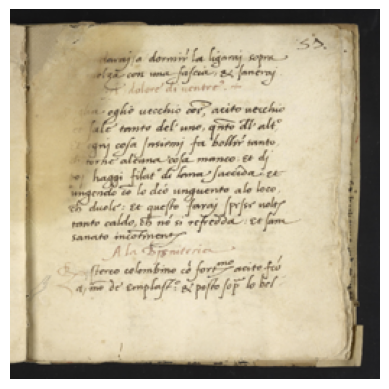

In [18]:
plt.imshow(image_a[0])
plt.axis('off')  # Optional: remove axis ticks
plt.show()